# Extraer espetrogramas

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
from itertools import cycle
from typing import Tuple

%pip install opencv-python librosa numpy matplotlib
%pip install ipywidgets
import cv2
import librosa
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [20]:
hparams = {
    'batch_size': 100,
    'num_epochs': 20,
    'learning_rate': 0.00002,
    'betas': (0.5, 0.999),
    'num_val_samples': 4,
    'input_channels': 1,
    'output_channels': 3
}

### Dataset and Data Loader
Download and prepare dataset and datalaoder


In [9]:
import os
from torch.utils.data import Dataset, DataLoader

# Change directory to the folder containing the videos
os.chdir(r'C:/Users/David/Documents/postgrau/Projecte/raining')

# Get a list of all .mp4 files in the folder
video_files = [f for f in os.listdir('.') if f.endswith('.mp4')]

# Create the 'frames' directory if it doesn't exist
if not os.path.exists('frames'):
    os.makedirs('frames')

# Loop through each video file
for video_file in video_files:
    # Load the video
    cap = cv2.VideoCapture(video_file)

    # Initialize frame and spectrogram lists
    frames = []
    spectrograms = []

    # Get the total duration of the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_duration = total_frames / fps

    # Extract frames and spectrograms
    frame_time = 0  # initialize frame time to 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to 128x128
        frame = cv2.resize(frame, (256, 256))

        # Extract audio and convert to spectrogram
        # Load a short segment of audio centered around the current frame

        # Pad the audio appropriately for the first and last frames
        if frame_time < 0.5:
            # For the first frames, load audio from the start and pad the beginning
            padding_duration = 0.5 - frame_time
            y, sr = librosa.load(video_file, sr=None, offset=0, duration=frame_time + 0.5)
            y_padded = np.pad(y, (int(sr * padding_duration), 0), 'constant')
        elif frame_time > total_duration - 0.5:
            # For the last frames, load audio from the end and pad the end
            padding_duration = 0.5 - (total_duration - frame_time)
            audio_offset = frame_time - 0.5
            y, sr = librosa.load(video_file, sr=None, offset=audio_offset, duration=1 - padding_duration)
            y_padded = np.pad(y, (0, int(sr * padding_duration)), 'constant')
        else:
            # For all other frames, load 1 second of audio as before
            y, sr = librosa.load(video_file, sr=None, offset=frame_time - 0.5, duration=1)
            y_padded = y

        win_length = 256  # window length in samples
        hop_length = 64  # hop length in samples
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_padded, win_length=win_length, hop_length=hop_length)), ref=np.max)

        # Resize spectrogram to 128x128
        D = cv2.resize(D, (256, 256))

        spectrograms.append(D)

        # Save frame and spectrogram to the 'frames' directory using the frame time as the filename
        frame_filename = 'frames/{}_{:.3f}_frame.npy'.format(video_file.split('.')[0], frame_time)
        spectrogram_filename = 'frames/{}_{:.3f}_spectrogram.npy'.format(video_file.split('.')[0], frame_time)
        np.save(frame_filename, frame)
        np.save(spectrogram_filename, spectrograms[-1])

        print(f'Saved {frame_filename} and {spectrogram_filename}')

        frames.append(frame)
        frame_time += 1 / fps  # increment frame time by the duration of one frame

    cap.release()

# Ensure the 'results' directory exists
os.makedirs('results', exist_ok=True)

# Rest of the code for DataLoader, model definition, and training loop...




C:\Users\David\AppData\Local\Temp\ipykernel_9336\3757141186.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_file, sr=None, offset=0, duration=frame_time + 0.5)


Saved frames/-Rq1BtCE_yo#21140#21150_0.000_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.000_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.100_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.100_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.200_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.200_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.300_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.300_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.400_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.400_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.500_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.500_spectrogram.npy


C:\Users\David\AppData\Local\Temp\ipykernel_9336\3757141186.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_file, sr=None, offset=frame_time - 0.5, duration=1)


Saved frames/-Rq1BtCE_yo#21140#21150_0.600_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.600_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.700_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.700_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.800_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.800_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_0.900_frame.npy and frames/-Rq1BtCE_yo#21140#21150_0.900_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_1.000_frame.npy and frames/-Rq1BtCE_yo#21140#21150_1.000_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_1.100_frame.npy and frames/-Rq1BtCE_yo#21140#21150_1.100_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_1.200_frame.npy and frames/-Rq1BtCE_yo#21140#21150_1.200_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_1.300_frame.npy and frames/-Rq1BtCE_yo#21140#21150_1.300_spectrogram.npy
Saved frames/-Rq1BtCE_yo#21140#21150_1.400_frame.npy and frames/-Rq1BtCE_yo#21140#21150_1.400_spectrogram.npy
Saved fram

C:\Users\David\AppData\Local\Temp\ipykernel_9336\3757141186.py:51: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_file, sr=None, offset=audio_offset, duration=1 - padding_duration)


Saved frames/07jWvsTfWXk#89#99_0.000_frame.npy and frames/07jWvsTfWXk#89#99_0.000_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.100_frame.npy and frames/07jWvsTfWXk#89#99_0.100_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.200_frame.npy and frames/07jWvsTfWXk#89#99_0.200_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.300_frame.npy and frames/07jWvsTfWXk#89#99_0.300_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.400_frame.npy and frames/07jWvsTfWXk#89#99_0.400_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.500_frame.npy and frames/07jWvsTfWXk#89#99_0.500_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.600_frame.npy and frames/07jWvsTfWXk#89#99_0.600_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.700_frame.npy and frames/07jWvsTfWXk#89#99_0.700_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.800_frame.npy and frames/07jWvsTfWXk#89#99_0.800_spectrogram.npy
Saved frames/07jWvsTfWXk#89#99_0.900_frame.npy and frames/07jWvsTfWXk#89#99_0.900_spectrogram.npy
Saved frames/07jWvsT

In [10]:
# Change directory to the folder containing the frames and spectrograms
os.chdir('C:/Users/David/Documents/postgrau/Projecte/raining/frames')

# Normalizing data
class FrameSpectrogramDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.frame_files = [f for f in os.listdir(root_dir) if f.endswith('_frame.npy')]

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        frame_file = self.frame_files[idx]
        frame = np.load(os.path.join(self.root_dir, frame_file))
        spectrogram_file = frame_file.replace('_frame.npy', '_spectrogram.npy')
        spectrogram = np.load(os.path.join(self.root_dir, spectrogram_file))

        # Convert numpy arrays to PyTorch tensors with the same data type
        frame = torch.from_numpy(frame.astype(np.float32))
        spectrogram = torch.from_numpy(spectrogram.astype(np.float32))

        # Normalize to [-1, 1]
        frame = (frame / 127.5) - 1
        spectrogram = (spectrogram / 127.5) - 1

        return frame, spectrogram

# Create a dataset
dataset = FrameSpectrogramDataset('.')

# Create a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=hparams['batch_size'],
    shuffle=True,
)

In [11]:
dataset = FrameSpectrogramDataset('.')
print(len(dataset))

13500


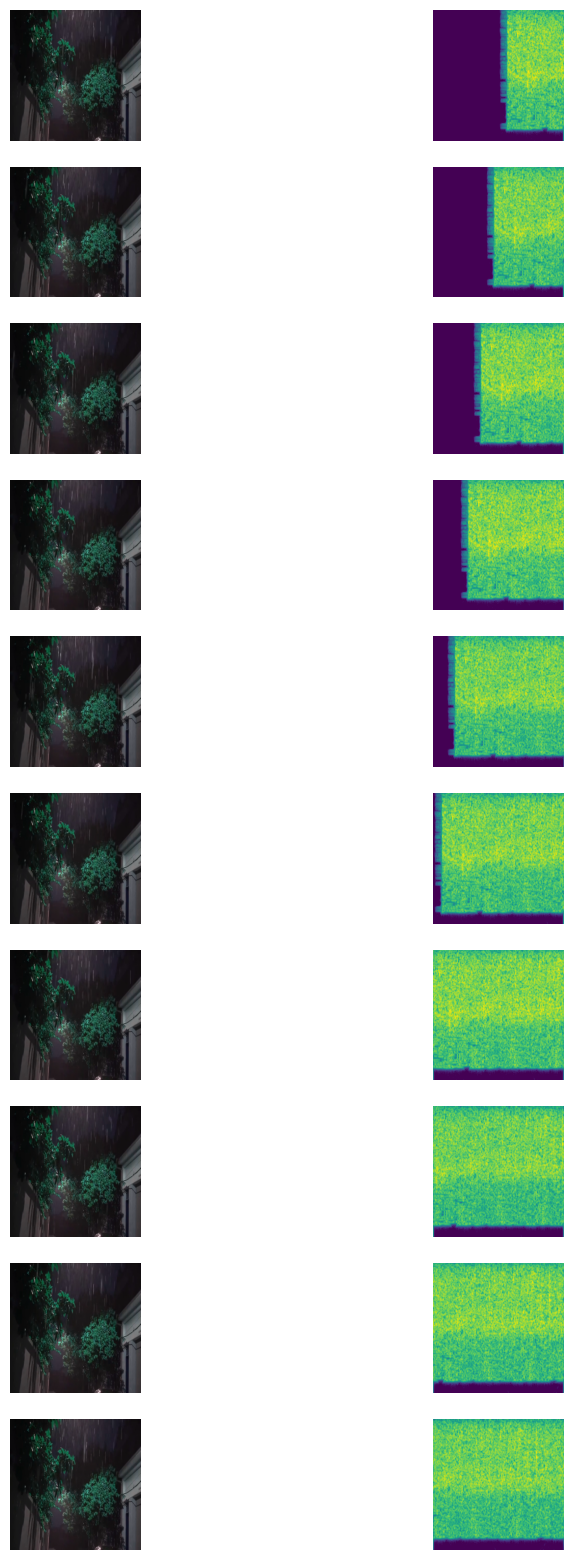

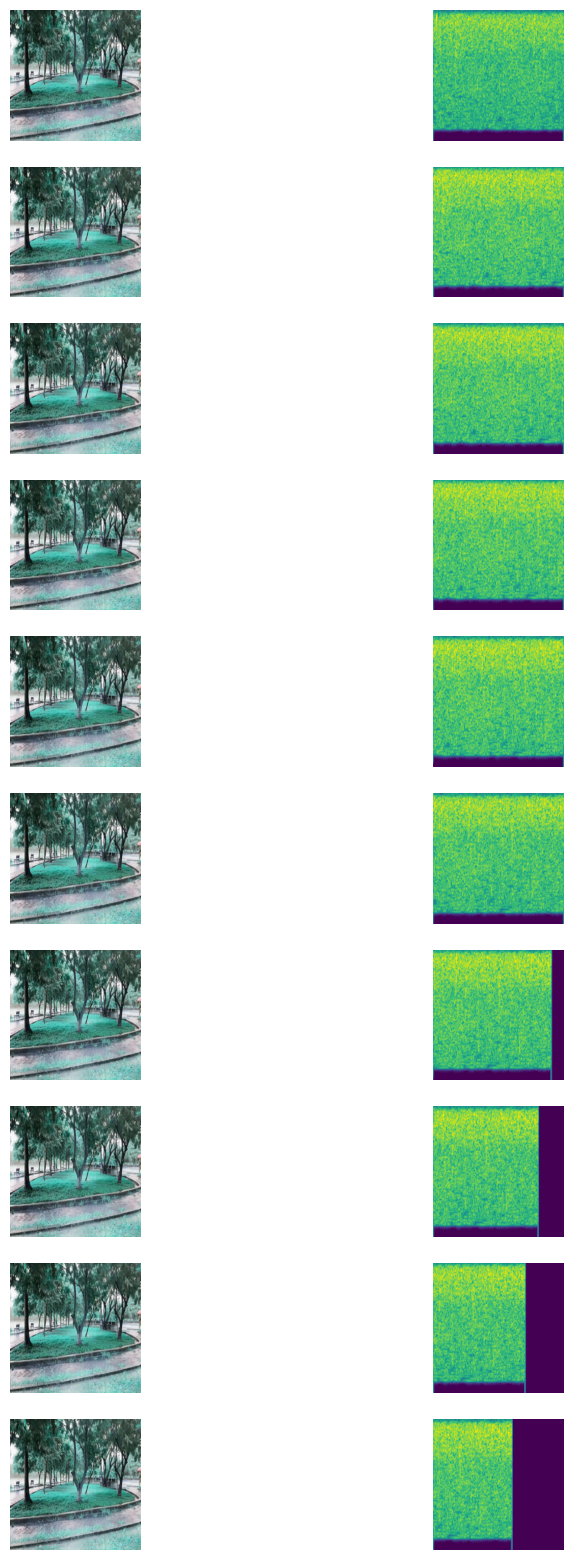

In [12]:
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    return tensor

# Get the first 10 pairs of data from the dataset
first_10_pairs = [dataset[i] for i in range(10)]

# Get the last 10 pairs of data from the dataset
last_10_pairs = [dataset[i] for i in range(-10, 0)]

# Plot the first 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, spectrogram) in enumerate(first_10_pairs):
    frame = denormalize(frame.numpy())  # Denormalize and rearrange dimensions
    spectrogram = denormalize(spectrogram.numpy())  # Denormalize

    axs[i, 0].imshow(frame)
    axs[i, 1].imshow(spectrogram, cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

# Plot the last 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, spectrogram) in enumerate(last_10_pairs):
    frame = denormalize(frame.numpy())  # Denormalize and rearrange dimensions
    spectrogram = denormalize(spectrogram.numpy())  # Denormalize

    axs[i, 0].imshow(frame)
    axs[i, 1].imshow(spectrogram, cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

GAN

In [15]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, input_channels=1, output_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            layers.append(nn.BatchNorm2d(out_channels))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.down1 = down_block(input_channels, 64, batch_norm=False)  # Output: (64, H/2=64, W/2)
        self.down2 = down_block(64, 128)                              # Output: (128, H/4=32, W/4)
        self.down3 = down_block(128, 256)                             # Output: (256, H/8=16, W/8)
        self.down4 = down_block(256, 512)                             # Output: (512, H/16=8, W/16)
        self.down5 = down_block(512, 512)                             # Output: (512, H/32=4, W/32)
        self.down6 = down_block(512, 512)                             # Output: (512, H/64=2, W/64)
        self.down7 = down_block(512, 512)                               # Output: (512, H/128=1, W/128)
        self.down8 = down_block(512, 512, batch_norm=False)
                                                                    
                                                                        

        self.up1 = up_block(512, 512, dropout=0.5)                         # Input: (512, H/128=1, W/128), Output: (512, H/64, W/64)
        self.up2 = up_block(1024, 512, dropout=0.5)                   # Input: (512 + 512, H/64=2, W/64), Output: (512, H/32, W/32)
        self.up3 = up_block(1024, 512, dropout=0.5)                   # Input: (512 + 512, H/32=4, W/32), Output: (512, H/16, W/16)
        self.up4 = up_block(1024, 512)                                # Input: (512 + 512, H/16=8, W/16), Output: (512, H/8, W/8)
        self.up5 = up_block(1024, 256)                                # Input: (512 + 512, H/8=16, W/8), Output: (256, H/4, W/4)
        self.up6 = up_block(512, 128)                                 # Input: (256 + 256, H/4=32, W/4), Output: (128, H/2, W/2)
        self.up7 = up_block(256, 64)                                  # Input: (128 + 128, H/2=64, W/2), Output: (64, H, W)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )                                                            # Input: (64 + 64, H, W), Output: (3, 2H, 2W)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)                                         # Output: (512, H/64, W/64)
        u2 = self.up2(torch.cat([u1, d7], 1))                         # Output: (512, H/32, W/32)
        u3 = self.up3(torch.cat([u2, d6], 1))                         # Output: (512, H/16, W/16)
        u4 = self.up4(torch.cat([u3, d5], 1))                         # Output: (512, H/8, W/8)
        u5 = self.up5(torch.cat([u4, d4], 1))                         # Output: (256, H/4, W/4)
        u6 = self.up6(torch.cat([u5, d3], 1))                         # Output: (128, H/2, W/2)
        u7 = self.up7(torch.cat([u6, d2], 1))                         # Output: (64, H, W)
        u8 = self.up8(torch.cat([u7, d1], 1))                          # Output: (3, 2H, 2W)
        
        return u8


# Properly initialize the weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [16]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_channels=4):
        super(PatchGANDiscriminator, self).__init__()
        
        def disc_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        self.model = nn.Sequential(
            disc_block(input_channels, 64, batch_norm=False),  # First layer should match input_channels
            disc_block(64, 128),
            disc_block(128, 256),
            disc_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [17]:
# Initialize models
netG = UNetGenerator(input_channels=hparams['input_channels'], output_channels=hparams['output_channels']).to(device)
netD = PatchGANDiscriminator(input_channels=hparams['input_channels'] + hparams['output_channels']).to(device)

# Apply weight initialization
netG.apply(weights_init_normal)
netD.apply(weights_init_normal)

# Initialize optimizers
optimizerG = optim.Adam(netG.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
optimizerD = optim.Adam(netD.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

# Initialize loss function
criterion = nn.BCELoss()

Train

Epoch [0/20], Step [0/135], Loss D: 0.6870, Loss G: 11.7219
Epoch [0/20], Step [50/135], Loss D: 0.5993, Loss G: 12.5235
Epoch [0/20], Step [100/135], Loss D: 0.5664, Loss G: 11.4685
Epoch [1/20], Step [0/135], Loss D: 0.7195, Loss G: 11.2130
Epoch [1/20], Step [50/135], Loss D: 0.7359, Loss G: 11.0997
Epoch [1/20], Step [100/135], Loss D: 0.5614, Loss G: 10.5357
Epoch [2/20], Step [0/135], Loss D: 0.5311, Loss G: 11.6938
Epoch [2/20], Step [50/135], Loss D: 0.6162, Loss G: 11.4032
Epoch [2/20], Step [100/135], Loss D: 0.5120, Loss G: 12.0369
Epoch [3/20], Step [0/135], Loss D: 1.5939, Loss G: 11.6691
Epoch [3/20], Step [50/135], Loss D: 0.7555, Loss G: 10.6029
Epoch [3/20], Step [100/135], Loss D: 0.5122, Loss G: 10.7208
Epoch [4/20], Step [0/135], Loss D: 0.6046, Loss G: 11.2569
Epoch [4/20], Step [50/135], Loss D: 0.8191, Loss G: 10.4576
Epoch [4/20], Step [100/135], Loss D: 0.5102, Loss G: 11.1836
Epoch [5/20], Step [0/135], Loss D: 0.7218, Loss G: 10.7144
Epoch [5/20], Step [50/13

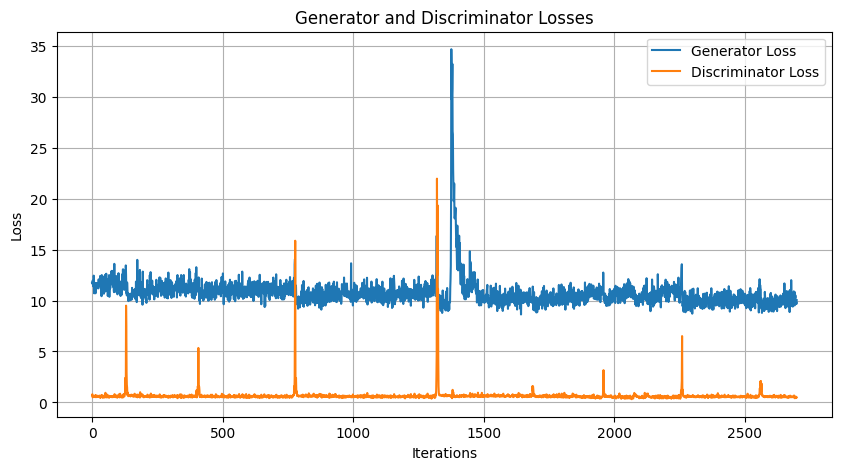

In [22]:
# Lists to store the losses
losses_G = []
losses_D = []

# Training loop
for epoch in range(hparams['num_epochs']):
    for i, (real_frames, spectrograms) in enumerate(dataloader):
        real_frames = real_frames.to(device)
        spectrograms = spectrograms.to(device)

        # Ensure the spectrograms have the correct channel dimension
        spectrograms = spectrograms.unsqueeze(1)  # (N, 1, H, W)
        real_frames = real_frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        # Generate fake frames
        fake_frames = netG(spectrograms)

        # Forward pass real frames through D to determine the output size
        with torch.no_grad():
            real_inputs = torch.cat((spectrograms, real_frames), 1)
            output_real = netD(real_inputs)
            label_shape = output_real.shape  # Get the shape of the discriminator output

        # Create labels with the correct shape
        real_labels = torch.ones(label_shape).to(device)
        fake_labels = torch.zeros(label_shape).to(device)

        # ----------------------
        # Update Discriminator
        # ----------------------
        optimizerD.zero_grad()

        # Forward pass real frames through D
        output_real = netD(real_inputs)
        lossD_real = criterion(output_real, real_labels)

        # Forward pass fake frames through D
        fake_inputs = torch.cat((spectrograms, fake_frames.detach()), 1)
        output_fake = netD(fake_inputs)
        lossD_fake = criterion(output_fake, fake_labels)

        # Compute total discriminator loss
        lossD = (lossD_real + lossD_fake) * 0.5
        lossD.backward()
        optimizerD.step()

        # ------------------
        # Update Generator
        # ------------------
        optimizerG.zero_grad()

        # Forward pass fake frames through D
        fake_inputs = torch.cat((spectrograms, fake_frames), 1)
        output_fake = netD(fake_inputs)
        lossG = criterion(output_fake, real_labels) + torch.mean(torch.abs(real_frames - fake_frames)) * 100  # Add L1 loss

        lossG.backward()
        optimizerG.step()

        # Append losses to lists
        losses_G.append(lossG.item())
        losses_D.append(lossD.item())

        # Print statistics
        if i % 50 == 0:
            print(f'Epoch [{epoch}/{hparams["num_epochs"]}], Step [{i}/{len(dataloader)}], '
                  f'Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}')
    
    # Save generated images for each epoch
    with torch.no_grad():
        fake_frames = netG(spectrograms[:hparams['num_val_samples']])
        fake_frames_denormalized = denormalize(fake_frames)  # Denormalize the generated images
        img_grid = make_grid(fake_frames_denormalized, nrow=hparams['num_val_samples'])
        save_image(img_grid, f'results/epoch_{epoch}.png')

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid(True)
plt.show()

Save model

In [23]:
# Save the model weights
torch.save(netG.state_dict(), 'model_weights-5.pth')

Load model

In [18]:
import torch
from torchvision.utils import save_image, make_grid

# Assuming UNetGenerator is defined as above
# Load the model weights
netG = UNetGenerator(input_channels=1, output_channels=3)
netG.load_state_dict(torch.load('model_weights-3.pth'))
netG.eval()  # Set the model to evaluation mode

UNetGenerator(
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down5): Sequential(
    (0): Conv2d(512,

Inference from new data

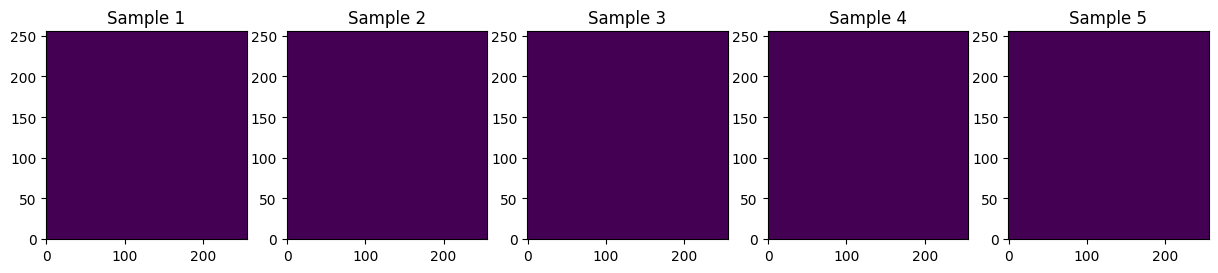

In [24]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

# Function to denormalize images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    return tensor


# Dataset definition for inference
class SpectrogramNPYDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.npy_files = [f for f in os.listdir(folder_path) if f.endswith('_spectrogram.npy')]
        self.transform = transform  # Assign the transform function

    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        npy_name = os.path.join(self.folder_path, self.npy_files[idx])
        spectrogram = np.load(npy_name)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)

        # Normalize to [-1, 1]
        spectrogram = (spectrogram / 127.5) - 1

        #Flip
        #spectrogram = F.vflip(spectrogram)

        if len(spectrogram.shape) == 2:  # Ensure it has the channel dimension
            spectrogram = spectrogram.unsqueeze(0)
        return spectrogram
    
# Define the transformation
transform = transforms.Compose([
])

# Create the dataset and dataloader for inference
folder_path = 'C:/Users/David/Documents/postgrau/Projecte/raining/frames/Inference Spectrograms'
inference_dataset = SpectrogramNPYDataset(folder_path, transform=transform)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False)

# Visualize a few spectrograms
def visualize_spectrograms(dataset, num_samples=5):
    plt.figure(figsize=(15, 2.7))
    for i in range(num_samples):
        spectrogram = dataset[i].squeeze().numpy()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(spectrogram, aspect='auto', origin='lower')
        plt.title(f'Sample {i+1}')
    plt.show()

visualize_spectrograms(inference_dataset, num_samples=5)


In [25]:

# Move model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG.to(device)

# Create a directory to save individual frames if it doesn't exist
os.makedirs('results/individual_frames', exist_ok=True)

# Perform inference and save the generated frames
with torch.no_grad():
    for batch_idx, spectrograms in enumerate(inference_loader):
        spectrograms = spectrograms.to(device)  # Spectrograms already have channel dimension
        fake_frames = netG(spectrograms)
        fake_frames = denormalize(fake_frames)  # Denormalize the images
        
        # Save individual frames
        for i, frame in enumerate(fake_frames):
            save_image(frame, f'results/individual_frames/frame_{batch_idx * inference_loader.batch_size + i + 1}.png')
        

Make video

In [26]:
%pip install opencv-python

import os
import cv2

# Directory containing the frames
frames_dir = 'results/individual_frames'

# Path to save the video
video_path = 'results/output_video_5.mp4'

# Frames per second
fps = 30

# Get the list of all frame files and sort them numerically
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')],
                     key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read the first frame to get the dimensions
first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, layers = first_frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

# Write each frame to the video
for frame_file in frame_files:
    frame_path = os.path.join(frames_dir, frame_file)
    frame = cv2.imread(frame_path)
    video.write(frame)

# Release the VideoWriter object
video.release()

print(f'Video saved at {video_path}')


Note: you may need to restart the kernel to use updated packages.
Video saved at results/output_video_5.mp4
